In [255]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
from matplotlib.offsetbox import AnchoredText

In [256]:
DATA_FOLDER = 'data/'
WIKISPEEDIA_PATHS = DATA_FOLDER + "wikispeedia_paths-and-graph/"

ARTICLES = WIKISPEEDIA_PATHS + "articles.tsv"
CATEGORIES = WIKISPEEDIA_PATHS + "categories.tsv"
LINKS = WIKISPEEDIA_PATHS + "links.tsv"
PATHS_FINISHED = WIKISPEEDIA_PATHS + "paths_finished.tsv"
PATHS_UNFINISHED = WIKISPEEDIA_PATHS + "paths_unfinished.tsv"
SHORTEST_PATHS = WIKISPEEDIA_PATHS + "shortest-path-distance-matrix.txt"
FEMALES = DATA_FOLDER + "listwomen.txt"
ALL_PATHS = DATA_FOLDER + "all_paths_overview.csv"
PEOPLE_OVERVIEW = DATA_FOLDER + "people_overview.csv"

In [257]:
articles = pd.read_csv(ARTICLES, sep='\t', names=["article"], skiprows = 12)
categories = pd.read_csv(CATEGORIES, sep='\t', names=["article", "category"], skiprows = 13)
links = pd.read_csv(LINKS, sep='\t', names=["link_source", "link_target"], skiprows = 12)
paths_finished = pd.read_csv(PATHS_FINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                              "durationInSec", "path", "rating"], skiprows = 15)
paths_unfinished = pd.read_csv(PATHS_UNFINISHED, sep='\t', names=["hashedIpAddress", "timestamp", 
                                                                  "durationInSec", "path", "target", "type"], skiprows = 17)
shortest_distance_text = np.loadtxt(SHORTEST_PATHS, dtype=str, comments="#", unpack=False)
female = pd.read_csv(FEMALES, sep=',', names=["name", "women_label"], skiprows = 1)
all_paths_overview = pd.read_csv(ALL_PATHS).drop(columns = ['Unnamed: 0'])
people_overview = pd.read_csv(PEOPLE_OVERVIEW).drop(columns = ['Unnamed: 0'])

Choose subsets of all_paths_overview as the data points. 

In [258]:
people_overview

,name,category,gender,nr_link_out,nr_link_in,tot_target_count,unf_target_count,fin_target_count,succ_rate
0,Abel_Tasman,Geographers_and_explorers,male,14,5,9.0,2.0,7.0,0.777778
1,Abraham_Lincoln,USA_Presidents,male,35,62,37.0,2.0,35.0,0.945946
2,Adam_Smith,Historical_figures,male,27,38,11.0,2.0,9.0,0.818182
3,Adolf_Hitler,Political_People,male,78,109,697.0,94.0,603.0,0.865136
4,Agamemnon,Historical_figures,male,11,9,26.0,7.0,19.0,0.730769
...,...,...,...,...,...,...,...,...,...
616,Zhang_Qian,Historical_figures,male,19,3,1.0,1.0,NaN,NaN
617,Zheng_He,Historical_figures,male,39,8,7.0,2.0,5.0,0.714286
618,Ziad_Jarrah,Historical_figures,male,25,1,15.0,10.0,5.0,0.333333
619,Zionism,Political_People,male,74,25,12.0,2.0,10.0,0.833333


In [259]:
# all paths with people as targets

people_target_paths = all_paths_overview.merge(people_overview[['name', 'category', 'gender']], 
                                          how = "inner", left_on = "target", right_on = "name")

women_target_paths = people_target_paths[people_target_paths['gender'] == "female"]
men_target_paths = people_target_paths[people_target_paths['gender'] == "male"]

In [260]:
# minimum requirement of matching: same source article
import networkx as nx

def matching():
    # minimum 1) match on source
    # 2) match on source and same shortest path link
    # 3) match on category and above
    # 4) match on nr_link_in 

    finished = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]
    all_paths = [nx.Graph(),nx.Graph(),nx.Graph(),nx.Graph()]


    for control_id, control_row in men_target_paths.iterrows():
        for treatment_id, treatment_row in women_target_paths.iterrows():
            if (control_row['finished'] == True and treatment_row['finished']):
                # Adds an edge only if the individuals have the same race
                if (control_row['source'] == treatment_row['source']):
                    # similarity = get_similarity(control_row['Propensity_score'],
                                                # treatment_row['Propensity_score'])
                    finished[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        finished[1].add_weighted_edges_from([(control_id, treatment_id, 1)])

                        if (control_row['category'] == treatment_row['category']):
                            finished[2].add_weighted_edges_from([(control_id, treatment_id, 1)])
            else:
                # Adds an edge only if the individuals have the same race
                if (control_row['source'] == treatment_row['source']):
                    # similarity = get_similarity(control_row['Propensity_score'],
                                                # treatment_row['Propensity_score'])
                    all_paths[0].add_weighted_edges_from([(control_id, treatment_id, 1)])
                    
                    if (control_row['shortest_path_length'] == treatment_row['shortest_path_length']):
                        all_paths[1].add_weighted_edges_from([(control_id, treatment_id, 1)])

                        if (control_row['category'] == treatment_row['category']):
                            all_paths[2].add_weighted_edges_from([(control_id, treatment_id, 1)])

    finished_dfs = []
    for g in finished:
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        finished_dfs.append(balanced_df_all)
    

    dfs = []
    for g in all_paths:
        matching = nx.max_weight_matching(g)
        matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
        balanced_df_all = people_target_paths.iloc[matched]
        dfs.append(balanced_df_all)

    return finished_dfs, dfs

In [261]:
# finished_dfs, dfs = matching()
# source_matching = dfs[0]
# source_matching.to_csv("./data/source_matched.csv")
# fin_source_matching = finished_dfs[0]
# fin_source_matching.to_csv("./data/fin_source_matched.csv")
# src_shp_match = dfs[1]
# src_shp_match.to_csv("./data/src_and_shp_matched.csv")
# fin_src_shp_match = finished_dfs[1]
# fin_src_shp_match.to_csv("./data/fin_src_and_shp_matched.csv")
# cat_and_rest = dfs[2]
# cat_and_rest.to_csv("./data/cat_and_rest_matched.csv")
# fin_cat_and_rest = finished_dfs[2]
# fin_cat_and_rest.to_csv("./data/fin_cat_and_rest_matched.csv")

Other matching ideas:
- create groups of categories
- create groups of links_in

In [469]:
src_match = pd.read_csv(DATA_FOLDER+"source_matched.csv").drop(columns = ['Unnamed: 0'])
shpath_match = pd.read_csv(DATA_FOLDER+"src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
cat_match = pd.read_csv(DATA_FOLDER+"cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])
fin_src_match = pd.read_csv(DATA_FOLDER+"fin_source_matched.csv").drop(columns = ['Unnamed: 0'])
fin_shpath_match = pd.read_csv(DATA_FOLDER+"fin_src_and_shp_matched.csv").drop(columns = ['Unnamed: 0'])
fin_cat_match = pd.read_csv(DATA_FOLDER+"fin_cat_and_rest_matched.csv").drop(columns = ['Unnamed: 0'])


In [470]:
def plot_2_dist(column, dataframe,bins = np.array([]), mytitle ="", myxlabel = "", myylabel="", ylog=False):
    female = dataframe[dataframe["gender"]== "female"][column]
    male = dataframe[dataframe["gender"]== "male"][column]
    # let's first check the distribution of both the male and the female data available
    if bins.size == 0:
        bins = np.arange(min(female)-0.5, max(female) + 0.5, 1)
    plt.hist(female, 
            color = 'tab:red', edgecolor = 'black', linewidth = 0.5, alpha=0.8, 
            bins= bins, label ="female")
    plt.hist(male, 
            color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.8,
            bins= bins, label ="male")

    plt.xlabel(myxlabel)
    plt.ylabel(myylabel)
    if ylog:
        plt.yscale('log')
    plt.title(mytitle)
    plt.axvline(np.median(female), color="red")
    plt.axvline(np.median(male),color="blue")
    plt.legend()
    plt.show()

In [471]:
def quantile_regression(column,dataframe, my_title="", my_xlabel = "", my_ylabel =""):
    mod = smf.quantreg(f'{column} ~ gender', dataframe).fit(q=0.5)
    print(mod.summary())
    conf = mod.conf_int()
    median_female = mod.params["Intercept"]
    median_male = median_female + mod.params["gender[T.male]"]
    uerr_female = conf.loc["Intercept"][1]-median_female
    lerr_female = conf.loc["Intercept"][1]-median_female
    uerr_male =  median_male - (median_female + conf.loc["gender[T.male]"][0])
    lerr_male =  median_male- (median_female + conf.loc["gender[T.male]"][0])
    error = np.array([[lerr_female, lerr_male], [uerr_female, uerr_male]])

    # Create lists for the plot
    genders = ['female', 'male']
    x_pos = np.arange(len(genders))
    medians = [median_female, median_male]

    fig, ax = plt.subplots()
    ax.bar(x_pos, medians, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel(my_ylabel)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(genders)
    ax.set_title(my_title)
    ax.yaxis.grid(True)


    at = AnchoredText(f"pairs = {int(dataframe[column].size/2)}", loc='lower right', prop=dict(size=8), frameon=True,
                       bbox_to_anchor=(0., 1.),
                       bbox_transform=ax.transAxes)
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

    # Save the figure and show
    # plt.tight_layout()
    plt.show()

In [472]:
fin_cat_match["gender"].value_counts()

male      6
female    6
Name: gender, dtype: int64

Results of matching (treatment group: women , control group: men): 
- Matching only on source (389 per group)
- Matching only on source & shortest path length (216 per group)
- Matching only on source & shortest path length & category (19 per group)




In [473]:
shpath_match = shpath_match.sort_values(by = "source", ascending=True)

In [474]:
# calculate successrate for targets in their matching groups

def add_success_rate(df): 
    df = df.drop(columns = ["name", "hashedIpAddress", "timestamp"])
    df["path_dev"] = df["human_path_length"] - df["shortest_path_length"]
    fin= df[df['finished'] == True]["target"].value_counts().reindex(df.target.unique(), fill_value=0)
    tot = df["target"].value_counts()
    success_rate = fin/tot
    success_rate = success_rate.rename("success_rate")
    df = df.merge(success_rate, how="left", left_on="target", right_index=True)
    # df["log_succ_rate"] = np.log(df["success_rate"])
    df["log_playtime"] = np.log(df["durationInSec"])
    return df


In [475]:
shpath_match = add_success_rate(shpath_match)
src_match = add_success_rate(src_match)
cat_match = add_success_rate(cat_match)
fin_shpath_match = add_success_rate(fin_shpath_match)
fin_src_match = add_success_rate(fin_src_match)
fin_cat_match = add_success_rate(fin_cat_match)

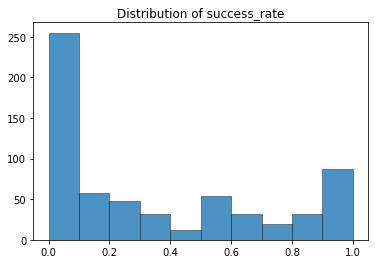

In [476]:
# plot the histogram
plt.hist(src_match["success_rate"], 
         color = 'tab:blue', edgecolor = 'black', linewidth = 0.5, alpha=0.8)
plt.xlabel("")
plt.ylabel("")
plt.title("Distribution of success_rate")
plt.show()

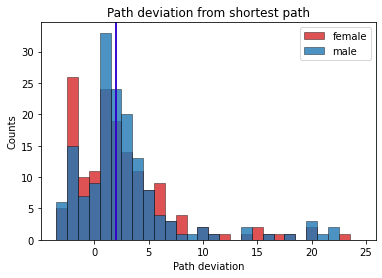

In [477]:
plot_2_dist("path_dev", shpath_match,mytitle="Path deviation from shortest path", myxlabel="Path deviation", myylabel="Counts")

<AxesSubplot:xlabel='gender', ylabel='rating'>

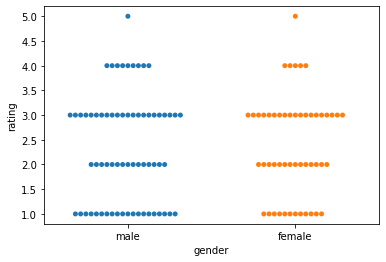

In [478]:
# plt.scatter(src_match["gender"], src_match["rating"])
sns.swarmplot(data= src_match, x="gender", y="rating")

Matching only on source and comparing the rating does not give any conclusive results, as the medians are the same. Looking at the data of all finished paths matched on the source, the rating is still inconclusive. 

In [479]:
corr=src_match.corr()
corr.style.background_gradient(cmap='coolwarm')

,finished,human_path_length,shortest_path_length,durationInSec,rating,backclicks,path_dev,success_rate,log_playtime
finished,1.000000,0.113634,-0.281031,-0.376563,nan,-0.014519,0.156389,0.770083,-0.264769
human_path_length,0.113634,1.000000,0.161114,0.126326,0.548946,0.757983,0.989443,-0.001840,0.316232
shortest_path_length,-0.281031,0.161114,1.000000,0.130340,0.386032,0.060955,0.016386,-0.370851,0.219458
durationInSec,-0.376563,0.126326,0.130340,1.000000,0.486704,0.138006,0.108842,-0.327671,0.850050
rating,nan,0.548946,0.386032,0.486704,1.000000,0.357700,0.511154,-0.157634,0.561320
backclicks,-0.014519,0.757983,0.060955,0.138006,0.357700,1.000000,0.758963,-0.057861,0.189230
path_dev,0.156389,0.989443,0.016386,0.108842,0.511154,0.758963,1.000000,0.052591,0.288150
success_rate,0.770083,-0.001840,-0.370851,-0.327671,-0.157634,-0.057861,0.052591,1.000000,-0.282729
log_playtime,-0.264769,0.316232,0.219458,0.850050,0.561320,0.189230,0.288150,-0.282729,1.000000


Noticed correlations on src_match
- success rate ~ finished (0.7)
- back clicks ~ path_dev & human_path_length (0.7)
- human_path_length ~ path_dev (0.9)
- durationInSec ~ rating (0.5)

***Are the paths to target articles about women longer than those for men?***

This requires the finished shortest path matching. They all have to be finished...

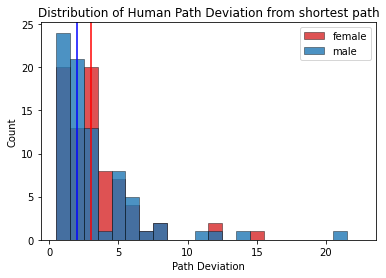

In [480]:
plot_2_dist("path_dev", fin_shpath_match, mytitle="Distribution of Human Path Deviation from shortest path", myxlabel="Path Deviation",myylabel="Count")


The plot shows us, that we have a power law so we use the log on the outcome path_dev for our regression. 

                         QuantReg Regression Results                          
Dep. Variable:               path_dev   Pseudo R-squared:              0.03526
Model:                       QuantReg   Bandwidth:                       1.394
Method:                 Least Squares   Sparsity:                        4.247
Date:                Thu, 15 Dec 2022   No. Observations:                  158
Time:                        17:47:25   Df Residuals:                      156
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.0000      0.239     12.558      0.000       2.528       3.472
gender[T.male]    -1.0000      0.338     -2.960      0.004      -1.667      -0.333


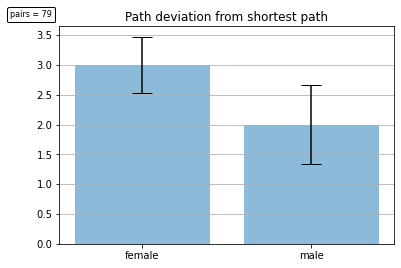

In [481]:
quantile_regression("path_dev",fin_shpath_match, "Path deviation from shortest path")

This data shows that out of finished paths that have the same source article and the same shortest path length, the ones going to the male target article have a median of 2 path_dev while the female target articles have a median of 3. However the confidence intervals overlap, so we cannot say for sure that the difference is significant. 

Let's take a look at the nr of backclicks. Do people searching for a female target have to go back more often, then to the male target. 

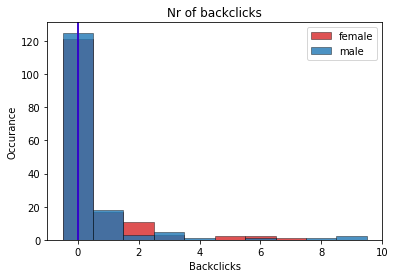

In [482]:
plot_2_dist("backclicks", shpath_match, mytitle="Nr of backclicks", myxlabel="Backclicks", myylabel="Occurance")

Since so many of the paths do not have any backclicks, the median and mean are all 0. Therefore there is no difference to be observed.

Next step is to only look at paths that have a backclick different from 0. 

                         QuantReg Regression Results                          
Dep. Variable:             backclicks   Pseudo R-squared:              0.01562
Model:                       QuantReg   Bandwidth:                      0.7745
Method:                 Least Squares   Sparsity:                        2.487
Date:                Thu, 15 Dec 2022   No. Observations:                  118
Time:                        17:47:26   Df Residuals:                      116
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0000      0.152      6.583      0.000       0.699       1.301
gender[T.male]     1.0000      0.231      4.328      0.000       0.542       1.458


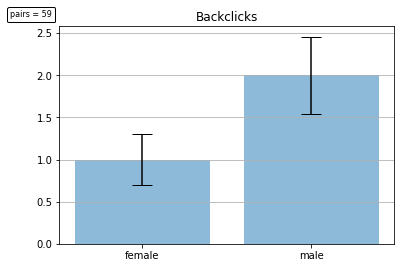

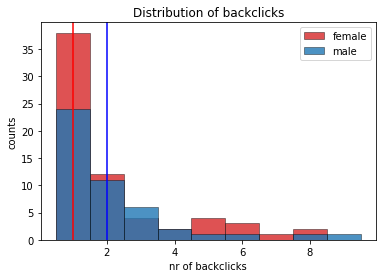

In [483]:
# the backclicks that differ from 0
backclicks = src_match[src_match["backclicks"]!= 0]
quantile_regression("backclicks", backclicks, "Backclicks")
plot_2_dist("backclicks", backclicks,mytitle="Distribution of backclicks", myxlabel="nr of backclicks", myylabel="counts")

If we only match by source, and look at paths that have a backclick that differs from 0. We see that there is a significant difference between the backclicks on male target articles compared to female articles. 

However as soon as we also match on the shortest path we do not have enough data. 

Let's take a look at the time the paths took. Because we know from the correlation analysis that the duration depends heavily on whether the path was finished or not, we will again only take a look at the finished paths.

In [484]:
fin_shpath_match.durationInSec.describe()

count     158.000000
mean      171.500000
std       219.102592
min        18.000000
25%        73.000000
50%       119.000000
75%       188.500000
max      1860.000000
Name: durationInSec, dtype: float64

In [485]:
female_playtime = fin_shpath_match[fin_shpath_match["gender"]== "female"]["durationInSec"]
male_playtime = fin_shpath_match[fin_shpath_match["gender"]== "male"]["durationInSec"]


In [486]:
female_cummulative=plt.hist(female_playtime,bins=1000,log=True,cumulative=-1,histtype='step')
male_cummulative=plt.hist(male_playtime,bins=1000,log=True,cumulative=-1,histtype='step')
plt.close()

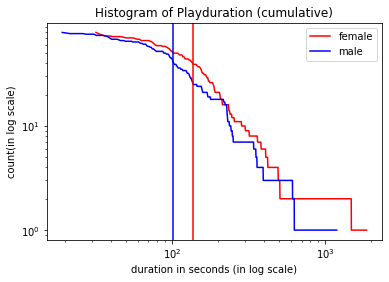

In [487]:
plt.loglog(female_cummulative[1][1:],female_cummulative[0], c='r', label= "female")
plt.loglog(male_cummulative[1][1:],male_cummulative[0], c='b', label= "male")
plt.title('Histogram of Playduration (cumulative)')
plt.ylabel('count(in log scale)')
plt.xlabel('duration in seconds (in log scale)')
plt.axvline(np.median(female_playtime), color="red")
plt.axvline(np.median(male_playtime), color="blue")
plt.legend()
plt.show()

                         QuantReg Regression Results                          
Dep. Variable:          durationInSec   Pseudo R-squared:              0.01401
Model:                       QuantReg   Bandwidth:                       75.78
Method:                 Least Squares   Sparsity:                        211.0
Date:                Thu, 15 Dec 2022   No. Observations:                  158
Time:                        17:47:30   Df Residuals:                      156
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        136.0000     11.872     11.455      0.000     112.549     159.451
gender[T.male]   -34.0000     16.790     -2.025      0.045     -67.165      -0.835


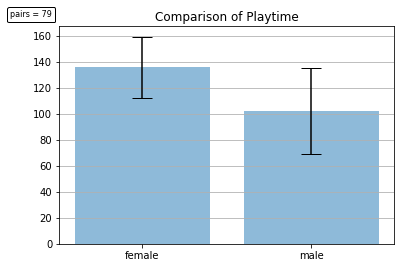

In [488]:
quantile_regression("durationInSec", fin_shpath_match, "Comparison of Playtime")

Comparing the successrates of the target articles in the matched set.

                         QuantReg Regression Results                          
Dep. Variable:           success_rate   Pseudo R-squared:            0.0007763
Model:                       QuantReg   Bandwidth:                      0.2115
Method:                 Least Squares   Sparsity:                        1.117
Date:                Thu, 15 Dec 2022   No. Observations:                  630
Time:                        17:50:06   Df Residuals:                      628
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2000      0.031      6.353      0.000       0.138       0.262
gender[T.male]     0.0500      0.045      1.123      0.262      -0.037       0.137


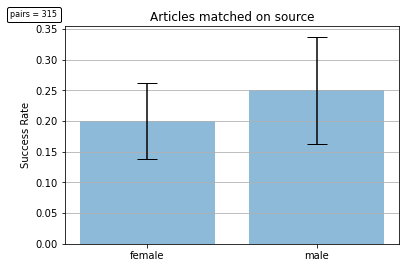

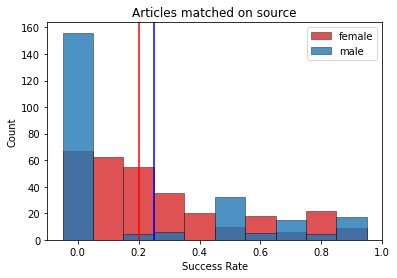

In [495]:
quantile_regression("success_rate", src_match,my_title= "Articles matched on source",my_ylabel="Success Rate" )
plot_2_dist("success_rate", src_match,bins= np.arange(0-0.05,1+0.05,0.1), mytitle= "Articles matched on source", myxlabel="Success Rate", myylabel="Count")

We can see that here, the median difference is not significant. The confidence intervals of the two groups overlap.

However if we start to filter out all targets that have a success rate of only 0, because they do not have a comparable counterpart, we can take a closer look.

In [503]:
# filter out all success rates == 0, because this means that it is not representable, as we have no positive version
non_zero_success_src = src_match[src_match["success_rate"] != 0.0]
non_zero_success_src["log_success_rate"] = np.log(non_zero_success_src["success_rate"])



/var/folders/32/zpjx_mxd2gs4f92mmd7g2ls40000gn/T/ipykernel_33666/2627986456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_success_src["log_success_rate"] = np.log(non_zero_success_src["success_rate"])


                         QuantReg Regression Results                          
Dep. Variable:           success_rate   Pseudo R-squared:               0.3114
Model:                       QuantReg   Bandwidth:                      0.1339
Method:                 Least Squares   Sparsity:                       0.6439
Date:                Thu, 15 Dec 2022   No. Observations:                  452
Time:                        17:53:50   Df Residuals:                      450
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2000      0.019     10.634      0.000       0.163       0.237
gender[T.male]     0.6889      0.032     21.724      0.000       0.627       0.751


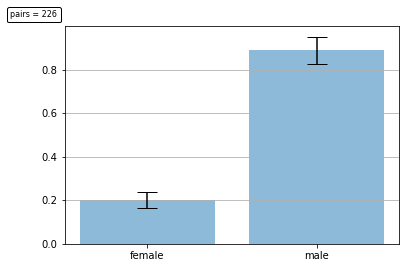

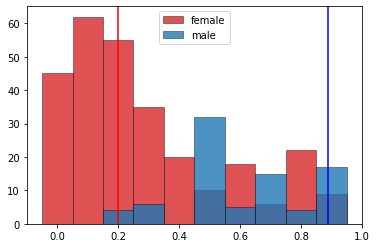

In [498]:
quantile_regression("success_rate", non_zero_success_src)
plot_2_dist("success_rate", non_zero_success_src,bins= np.arange(0-0.05,1+0.05,0.1))

Next step is comparing the success rate on a matched set with more constraints. The next step is also matching on the shortest path.

                         QuantReg Regression Results                          
Dep. Variable:           success_rate   Pseudo R-squared:               0.3947
Model:                       QuantReg   Bandwidth:                      0.1092
Method:                 Least Squares   Sparsity:                       0.2860
Date:                Thu, 15 Dec 2022   No. Observations:                  188
Time:                        17:55:20   Df Residuals:                      186
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2500      0.014     17.657      0.000       0.222       0.278
gender[T.male]     0.7500      0.021     35.825      0.000       0.709       0.791


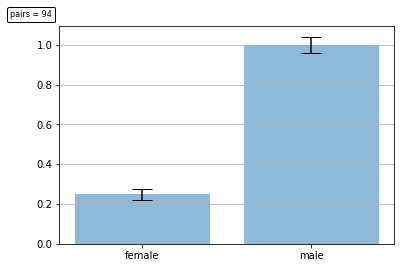

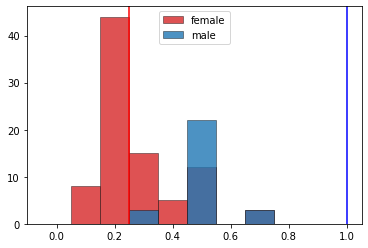

In [500]:
non_zero_success_shp = shpath_match[shpath_match["success_rate"] !=0]

quantile_regression("success_rate", non_zero_success_shp)
plot_2_dist("success_rate", non_zero_success_shp,bins= np.arange(0-0.05,1+0.05,0.1))

Matching even further on the factors, would mean to only include those target articles that are in the same subcategory. 

                         QuantReg Regression Results                          
Dep. Variable:           success_rate   Pseudo R-squared:           -6.651e-07
Model:                       QuantReg   Bandwidth:                      0.3415
Method:                 Least Squares   Sparsity:                       0.6071
Date:                Thu, 15 Dec 2022   No. Observations:                   28
Time:                        17:57:31   Df Residuals:                       26
                                        Df Model:                            1
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       7.472e-07      0.081   9.21e-06      1.000      -0.167       0.167
gender[T.male] -5.806e-07      0.115  -5.06e-06      1.000      -0.236       0.236


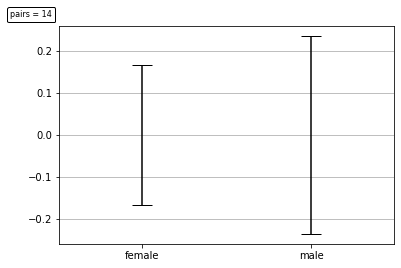

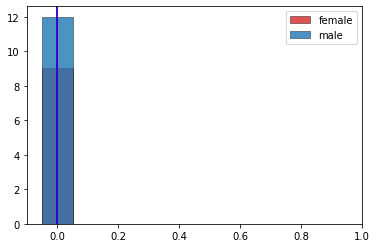

In [502]:
# non_zero_success_cat = cat_match[cat_match["success_rate"] !=0]

quantile_regression("success_rate", cat_match)
plot_2_dist("success_rate", cat_match,bins= np.arange(0-0.05,1+0.05,0.1))

This does not work, as all of the targets were never reached. 